# Cross-epoch geometry distance and behavioral correlations

For each task, compute tuning curves in cue, delay and response epochs.
Group neurons by monkey × age. Build PCA representations per epoch.
Compute Procrustes distance between delay–cue and delay–response per monkey–age pair.
Correlate with DI and RT.

In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import os, sys
sys.path.insert(0, '.')

from functions import (
    load_all_task_data,
    build_epoch_representations, cross_epoch_distances,
    load_behavioral_data, get_behavioral_values,
    plot_cross_epoch_correlations,
    p_to_stars,
    TASK_COLORS,
)

DATA_DIR     = '../data_raw'
BEH_SAC      = '../original_repo/behavior/sac_data.csv'
BEH_SAC_ODRD = '../original_repo/GAM/data/sac_odrd.csv'

N_PCS       = 8
MIN_NEURONS = 10
BIN_MS      = 25
N_AGE_BINS  = 3

# Cross-epoch uses late delay windows (different from default TASK_EPOCHS)
TASK_EPOCHS = {
    'ODR 1.5s': dict(t_range=(-1000, 2500),
                     epochs={'cue': (0, 500), 'delay': (1250, 2000), 'response': (2000, 2500)}),
    'ODR 3.0s': dict(t_range=(-1000, 3500),
                     epochs={'cue': (0, 500), 'delay': (1750, 3000), 'response': (3000, 3500)}),
    'ODRd':     dict(t_range=(-1000, 4000),
                     epochs={'cue': (0, 500), 'delay': (2200, 3000), 'response': (3000, 3500)}),
}

COMPARISONS = [('cue', 'delay'), ('delay', 'response'), ('cue', 'response')]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data

In [ ]:
task_data = load_all_task_data(DATA_DIR)
beh_df = load_behavioral_data(BEH_SAC, sac_odrd_path=BEH_SAC_ODRD)

for name, T in task_data.items():
    print(f'{name}: {T["data"].shape[0]} neurons, {T["data"].shape[1]} conditions')

## 2. Per-epoch PCA representations

In [ ]:
epoch_reps, age_groups, monkey_edges = build_epoch_representations(
    task_data, TASK_EPOCHS, N_PCS, MIN_NEURONS, bin_ms=BIN_MS, n_age_bins=N_AGE_BINS)

for task_name in TASK_EPOCHS:
    kept = epoch_reps[task_name][list(TASK_EPOCHS[task_name]['epochs'].keys())[0]]
    print(f'{task_name}: {len(kept)} entries per epoch')

  neuron 0/1180
  neuron 500/1180
  neuron 1000/1180
  neuron 0/922
  neuron 500/922
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319
ODR 1.5s: 24 entries per epoch
ODR 3.0s: 12 entries per epoch
ODRd: 12 entries per epoch


## 3. Cross-epoch Procrustes distances

In [ ]:
cross_epoch = cross_epoch_distances(epoch_reps, COMPARISONS)

for task_name in TASK_EPOCHS:
    for label, rows in cross_epoch[task_name].items():
        dists = [r['distance'] for r in rows]
        print(f'{task_name} {label}: {len(rows)} pairs, '
              f'mean={np.mean(dists):.4f}, std={np.std(dists):.4f}')

ODR 1.5s cue→delay: 24 pairs, mean=0.0960, std=0.0544
ODR 1.5s delay→response: 24 pairs, mean=0.1000, std=0.0495
ODR 1.5s cue→response: 24 pairs, mean=0.1102, std=0.0615
ODR 3.0s cue→delay: 12 pairs, mean=0.0591, std=0.0181
ODR 3.0s delay→response: 12 pairs, mean=0.0512, std=0.0212
ODR 3.0s cue→response: 12 pairs, mean=0.0536, std=0.0157
ODRd cue→delay: 12 pairs, mean=0.6024, std=0.0490
ODRd delay→response: 12 pairs, mean=0.5311, std=0.0527
ODRd cue→response: 12 pairs, mean=0.5757, std=0.0623


## 4. Behavioral correlations

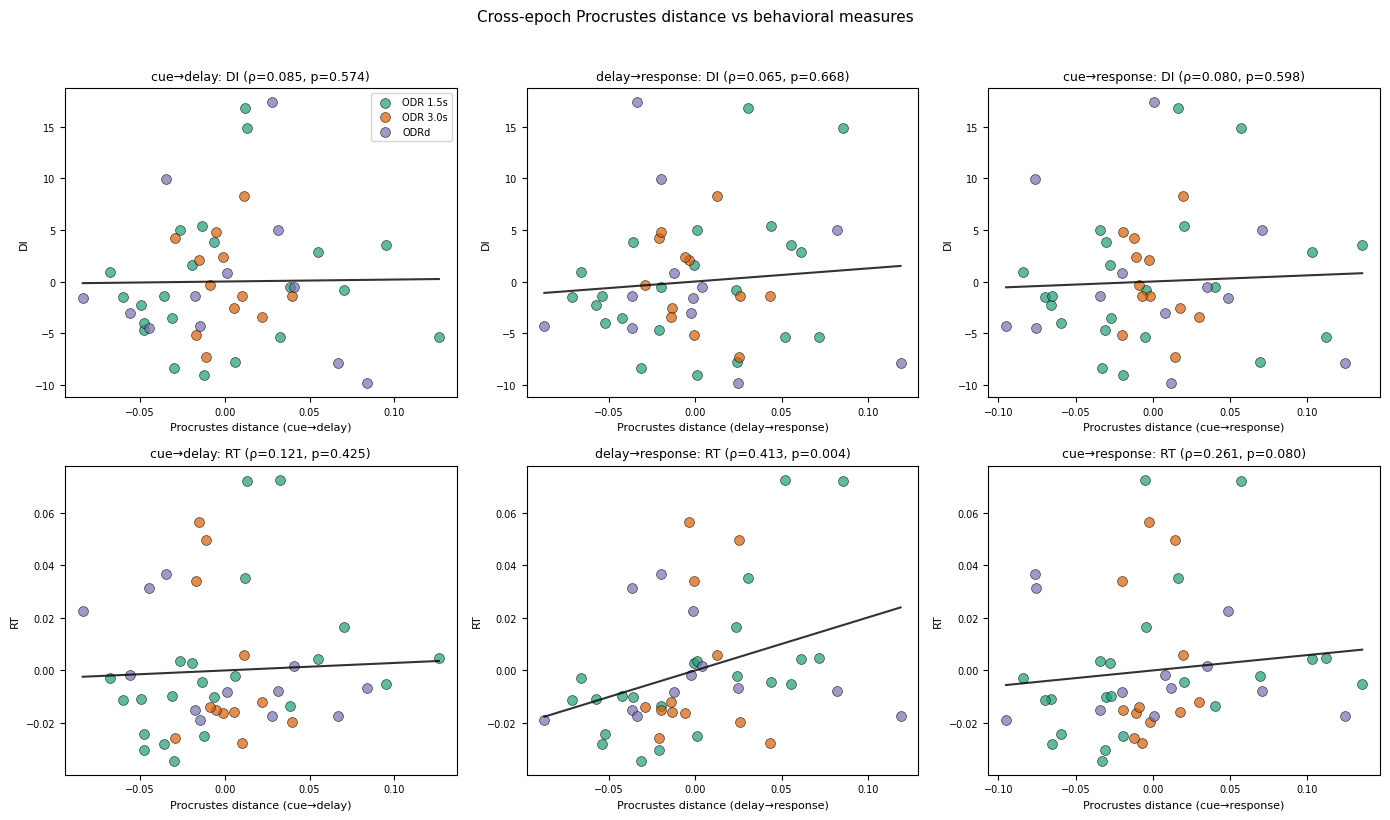

In [ ]:
plot_cross_epoch_correlations(cross_epoch, beh_df, monkey_edges, TASK_EPOCHS,
                               COMPARISONS, method='reg')

## 5. Summary: correlation matrices

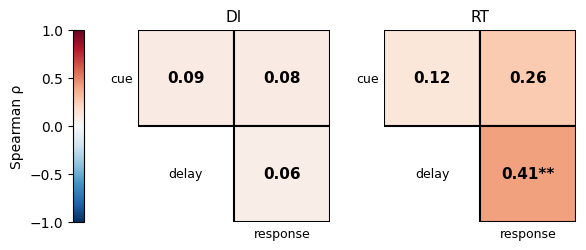

In [ ]:
from functions.behavior import get_behavioral_values
from functions.plotting import p_to_stars

epoch_names = ['cue', 'delay', 'response']
pairs = [('cue', 'delay'), ('cue', 'response'), ('delay', 'response')]

# Compute pooled Spearman rho for each pair x (DI, RT)
rho_vals = {}   # {beh_name: list of 3 rho}
p_vals = {}     # {beh_name: list of 3 p}

for beh_name in ['DI', 'RT']:
    rhos, ps = [], []
    for ea, eb in pairs:
        label = f'{ea}\u2192{eb}'
        all_d, all_beh = [], []
        for task_name in TASK_EPOCHS:
            rows = cross_epoch[task_name].get(label, [])
            if not rows:
                continue
            entries = [{'monkey': r['monkey'], 'group': r['group']} for r in rows]
            di_vals, rt_vals = get_behavioral_values(beh_df, entries, task_name, monkey_edges)
            beh_vals = di_vals if beh_name == 'DI' else rt_vals
            dists = np.array([r['distance'] for r in rows])
            valid = np.isfinite(beh_vals)
            all_d.extend(dists[valid] - np.mean(dists[valid]))
            all_beh.extend(beh_vals[valid] - np.mean(beh_vals[valid]))
        if len(all_d) >= 3:
            rho, p = sts.spearmanr(all_d, all_beh)
            rhos.append(rho)
            ps.append(p)
        else:
            rhos.append(np.nan)
            ps.append(np.nan)
    rho_vals[beh_name] = rhos
    p_vals[beh_name] = ps

# Layout: 2x2 grid, position (1,0) is blank
#                col0       col1
# row0 (cue)   [cue-del]  [cue-resp]
# row1           delay    [del-resp]
pos_map = {0: (0, 0), 1: (0, 1), 2: (1, 1)}  # pair index -> (row, col)

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = plt.cm.RdBu_r
norm = Normalize(vmin=-1, vmax=1)
sm = ScalarMappable(cmap=cmap, norm=norm)

fig, axes = plt.subplots(1, 3, figsize=(6.5, 2.5),
                          gridspec_kw={'width_ratios': [0.06, 1, 1], 'wspace': 0.4})

# Colorbar on the left
cb = fig.colorbar(sm, cax=axes[0], label='Spearman \u03c1')
axes[0].yaxis.set_ticks_position('left')
axes[0].yaxis.set_label_position('left')

for ax, beh_name in zip(axes[1:], ['DI', 'RT']):
    # Draw the 3 squares
    for k, (r, c) in pos_map.items():
        rho = rho_vals[beh_name][k]
        p = p_vals[beh_name][k]
        color = cmap(norm(rho)) if np.isfinite(rho) else 'lightgrey'
        ax.add_patch(plt.Rectangle((c, r), 1, 1, facecolor=color,
                                    edgecolor='k', linewidth=1.5))
        if np.isfinite(rho):
            stars = p_to_stars(p, ns_label='')
            ax.text(c + 0.5, r + 0.5, f'{rho:.2f}{stars}',
                    ha='center', va='center', fontsize=11, fontweight='bold')

    # Single "delay" label in the empty cell
    ax.text(0.5, 1.5, 'delay', ha='center', va='center', fontsize=9)


    ax.set_xlim(0, 2)
    ax.set_ylim(2, 0)
    # x-axis: skip delay (col 0), only label response (col 1)
    ax.set_xticks([1.5])
    ax.set_xticklabels(['response'], fontsize=9)
    # y-axis: only label cue (row 0)
    ax.set_yticks([0.5])
    ax.set_yticklabels(['cue'], fontsize=9)
    ax.tick_params(length=0)
    ax.set_aspect('equal')
    ax.set_title(beh_name, fontsize=11)
    ax.spines[:].set_visible(False)